# 1. Reading and Understanding Data

In [87]:
#importing all required library's
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Importing RFE and LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')

In [88]:
# Importing dataset

#read the csv
housingInfo = pd.read_csv(r'C:\Users\jg945e\Desktop\Ml1CaseStudy\train.csv', low_memory=False)


# 2. Data Cleaning and Manipulation

In [89]:
## DATA CLEANING & MANIPULATION STARTS FROM HERE

# check for unique rows. Are there or any duplicates?
print("No. of unique rows:", housingInfo.duplicated(subset=None, keep='first').count())


#Check any rows, columns are empty 
print("No. of empty rows: ", housingInfo.isnull().all(axis=1).sum()) 
print("No. of empty columns: ", housingInfo.isnull().all(axis=0).sum()) 

## At this point, after checking for duplicates, the unique rows is still the same. Lets retain all data assuming it's 
#necessary. 

No. of unique rows: 1460
No. of empty rows:  0
No. of empty columns:  0


In [90]:
#Removing/Imputing NaN values in Categorical attributes
#check for null values in all categorical columns

housingInfo.select_dtypes(include='object').isnull().sum()[housingInfo.select_dtypes(include='object').isnull().sum()>0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [91]:
# Replace NA with None in the following columns below : 

for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical'):
    
    housingInfo[col]=housingInfo[col].fillna('None')



In [92]:
#Remove categorical attributes that have more than 85% data associated to one value.

#We will remove any column that has one value repeating 1241 times (1241/1450)*100 = 85%) as this column would be skewed
#to one value

# Drop the following columns that have more than 85% values associated to a specific value

# Method to get the column names that have count of one value more than 85%

def getHighCategoricalValueCounts():
    column = []
    categorical_columns = housingInfo.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(housingInfo[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValueCounts()

# Remove the columns with skewed data

housingInfo.drop(columnsToBeRemoved, axis = 1, inplace = True)



In [93]:
# once again check for null values in all categorical columns

housingInfo.select_dtypes(include='object').isnull().sum()[housingInfo.select_dtypes(include='object').isnull().sum()>0]

Series([], dtype: int64)

In [94]:
#At this point, No more null values in the categorical variables

In [95]:
#Removing null values in Numerical attributes
# check the null values in the numerical data

housingInfo.select_dtypes(include=['int64','float']).isnull().sum()[housingInfo.select_dtypes(include=['int64','float']).isnull()
                                                                  .sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [96]:
# Impute the null values with median values for LotFrontage and MasVnrArea columns

housingInfo['LotFrontage'] = housingInfo['LotFrontage'].replace(np.nan, housingInfo['LotFrontage'].median())
housingInfo['MasVnrArea'] = housingInfo['MasVnrArea'].replace(np.nan, housingInfo['MasVnrArea'].median())

In [97]:
# Setting the null values with 0 for GarageYrBlt for now as we would be handling this column further below

housingInfo['GarageYrBlt']=housingInfo['GarageYrBlt'].fillna(0)
housingInfo['GarageYrBlt'] = housingInfo['GarageYrBlt'].astype(int)


In [98]:
# Create a new column named IsRemodelled - This column would determine whether the house has been remodelled or not based on 
# the difference between remodelled and built years

def checkForRemodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
housingInfo['IsRemodelled'] = housingInfo.apply(checkForRemodel, axis=1)


housingInfo.head()    

Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood BldgType HouseStyle  ...  3SsnPorch  ScreenPorch  PoolArea  \
0      CollgCr     1Fam     2Story  ...          0            0         0   
1      Veenker     1Fam     1Story  ...          0            0         0   
2      CollgCr     1Fam     2Story  ...          0            0         0   
3      Crawfor     1Fam     2Story  ...          0            0         0   
4      NoRidge     1Fam     2Story  ...          0            0         0   

   Fence MiscVal MoSold YrSold SaleCondition  SalePrice IsRemodelled  
0   None       0      2   2008        Normal     208500            0  
1   None       0      5   2007        Normal     181500            0  
2   None       0      9   2008        Normal     223500            1  
3   None       0      2   2006       Abnorml     140000            1  
4   None       0     12   2008        Normal     250000            0  

[5 rows x 61 columns]

In [99]:

# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def getBuiltOrRemodelAge(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
housingInfo['BuiltOrRemodelAge'] = housingInfo.apply(getBuiltOrRemodelAge, axis=1)
housingInfo.head()  



Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood BldgType HouseStyle  ...  ScreenPorch  PoolArea  Fence  \
0      CollgCr     1Fam     2Story  ...            0         0   None   
1      Veenker     1Fam     1Story  ...            0         0   None   
2      CollgCr     1Fam     2Story  ...            0         0   None   
3      Crawfor     1Fam     2Story  ...            0         0   None   
4      NoRidge     1Fam     2Story  ...            0         0   None   

   MiscVal MoSold YrSold SaleCondition SalePrice  IsRemodelled  \
0        0      2   2008        Normal    208500             0   
1        0      5   2007        Normal    181500             0   
2        0      9   2008        Normal    223500             1   
3        0      2   2006       Abnorml    140000             1   
4        0     12   2008        Normal    250000             0   

  BuiltOrRemodelAge  
0                 5  
1                31  
2                 6  
3                36  
4                 8  

[5 rows x 62 columns]

In [100]:
# Create a new column which would indicate if the Garage is old or new.
# Garage Yr Built less than 2000 will be considered as old (0) else new(1). 
# For GarageYrBuilt , where we have imputed the value as 0 will also be treated as old.

def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
housingInfo['OldOrNewGarage'] = housingInfo['GarageYrBlt'].apply(getGarageConstructionPeriod)
housingInfo.head() 

Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood BldgType HouseStyle  ...  PoolArea  Fence  MiscVal  MoSold  \
0      CollgCr     1Fam     2Story  ...         0   None        0       2   
1      Veenker     1Fam     1Story  ...         0   None        0       5   
2      CollgCr     1Fam     2Story  ...         0   None        0       9   
3      Crawfor     1Fam     2Story  ...         0   None        0       2   
4      NoRidge     1Fam     2Story  ...         0   None        0      12   

  YrSold SaleCondition SalePrice IsRemodelled  BuiltOrRemodelAge  \
0   2008        Normal    208500            0                  5   
1   2007        Normal    181500            0                 31   
2   2008        Normal    223500            1                  6   
3   2006       Abnorml    140000            1                 36   
4   2008        Normal    250000            0                  8   

  OldOrNewGarage  
0              1  
1              0  
2              1  
3              0  
4              1  

[5 rows x 63 columns]

In [101]:
# Since we have created new features from YearBuilt, YearRemodAdd, YrSold and GarageYrBlt, we can drop these columns as we 
# would only be using the derived columns for further analysis

housingInfo.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)

In [102]:
#Remove numerical attributes that have more than 85% data associated to one value.

#We will remove any column that has one value repeating 1241 times (1241/1450)*100 = 85%) as this column would be 
#skewed to one value


# Drop the following columns that have more than 85% values associated to a specific value
# We will also drop MoSold as we will not be using that for further analysis

def getHighNumericalValueCounts():
    column = []
    numerical_columns = housingInfo.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(housingInfo[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighNumericalValueCounts()
housingInfo.drop(columnsToBeRemoved, axis = 1, inplace = True)

housingInfo.drop(['MoSold'], axis = 1, inplace = True)

housingInfo.head()



Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood BldgType HouseStyle  ...  GarageCars  GarageArea WoodDeckSF  \
0      CollgCr     1Fam     2Story  ...           2         548          0   
1      Veenker     1Fam     1Story  ...           2         460        298   
2      CollgCr     1Fam     2Story  ...           2         608          0   
3      Crawfor     1Fam     2Story  ...           3         642          0   
4      NoRidge     1Fam     2Story  ...           3         836        192   

  OpenPorchSF Fence SaleCondition  SalePrice IsRemodelled BuiltOrRemodelAge  \
0          61  None        Normal     208500            0                 5   
1           0  None        Normal     181500            0                31   
2          42  None        Normal     223500            1                 6   
3          35  None       Abnorml     140000            1                36   
4          84  None        Normal     250000            0                 8   

  OldOrNewGarage  
0              1  
1              0  
2              1  
3              0  
4              1  

[5 rows x 49 columns]

In [103]:
# check for percentage of null values in each column

percent_missing = round(100*(housingInfo.isnull().sum()/len(housingInfo.index)), 2)
print(percent_missing)

Id                   0.0
MSSubClass           0.0
MSZoning             0.0
LotFrontage          0.0
LotArea              0.0
LotShape             0.0
LotConfig            0.0
Neighborhood         0.0
BldgType             0.0
HouseStyle           0.0
OverallQual          0.0
OverallCond          0.0
RoofStyle            0.0
Exterior1st          0.0
Exterior2nd          0.0
MasVnrType           0.0
MasVnrArea           0.0
ExterQual            0.0
Foundation           0.0
BsmtQual             0.0
BsmtExposure         0.0
BsmtFinType1         0.0
BsmtFinSF1           0.0
BsmtUnfSF            0.0
TotalBsmtSF          0.0
HeatingQC            0.0
1stFlrSF             0.0
2ndFlrSF             0.0
GrLivArea            0.0
BsmtFullBath         0.0
FullBath             0.0
HalfBath             0.0
BedroomAbvGr         0.0
KitchenQual          0.0
TotRmsAbvGrd         0.0
Fireplaces           0.0
FireplaceQu          0.0
GarageType           0.0
GarageFinish         0.0
GarageCars           0.0


In [104]:
#there are no null values in the dataset

In [105]:
##Outlier Treatment

# Checking outliers at 25%,50%,75%,90%,95% and above

housingInfo.describe(percentiles=[.25,.5,.75,.90,.95,.99])



Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    69.863699   10516.828082     6.099315   
std     421.610009    42.300571    22.027677    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
90%    1314.100000   120.000000    92.000000   14381.700000     8.000000   
95%    1387.050000   160.000000   104.000000   17401.150000     8.000000   
99%    1445.410000   190.000000   137.410000   37567.640000    10.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond   MasVnrArea   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean      5.575342   103.117123   443.639726   567.240411  1057.429452  ...   
std       1.112799   180.731373   456.098091   441.866955   438.705324  ...   
min       1.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       5.000000     0.000000     0.000000   223.000000   795.750000  ...   
50%       5.000000     0.000000   383.500000   477.500000   991.500000  ...   
75%       6.000000   164.250000   712.250000   808.000000  1298.250000  ...   
90%       7.000000   335.000000  1065.500000  1232.000000  1602.200000  ...   
95%       8.000000   456.000000  1274.000000  1468.000000  1753.000000  ...   
99%       9.000000   791.280000  1572.410000  1797.050000  2155.050000  ...   
max       9.000000  1600.000000  5644.000000  2336.000000  6110.000000  ...   

       TotRmsAbvGrd   Fireplaces   GarageCars   GarageArea   WoodDeckSF  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean       6.517808     0.613014     1.767123   472.980137    94.244521   
std        1.625393     0.644666     0.747315   213.804841   125.338794   
min        2.000000     0.000000     0.000000     0.000000     0.000000   
25%        5.000000     0.000000     1.000000   334.500000     0.000000   
50%        6.000000     1.000000     2.000000   480.000000     0.000000   
75%        7.000000     1.000000     2.000000   576.000000   168.000000   
90%        9.000000     1.000000     3.000000   757.100000   262.000000   
95%       10.000000     2.000000     3.000000   850.100000   335.000000   
99%       11.000000     2.000000     3.000000  1002.790000   505.460000   
max       14.000000     3.000000     4.000000  1418.000000   857.000000   

       OpenPorchSF      SalePrice  IsRemodelled  BuiltOrRemodelAge  \
count  1460.000000    1460.000000   1460.000000        1460.000000   
mean     46.660274  180921.195890      0.476712          22.950000   
std      66.256028   79442.502883      0.499629          20.640653   
min       0.000000   34900.000000      0.000000          -1.000000   
25%       0.000000  129975.000000      0.000000           4.000000   
50%      25.000000  163000.000000      0.000000          14.000000   
75%      68.000000  214000.000000      1.000000          41.000000   
90%     130.000000  278000.000000      1.000000          56.000000   
95%     175.050000  326100.000000      1.000000          58.000000   
99%     285.820000  442567.010000      1.000000          60.000000   
max     547.000000  755000.000000      1.000000          60.000000   

       OldOrNewGarage  
count     1460.000000  
mean         0.275342  
std          0.446840  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
90%          1.000000  
95%          1.000000  
99%          1.000000  
max          1.000000  

[11 rows x 27 columns]

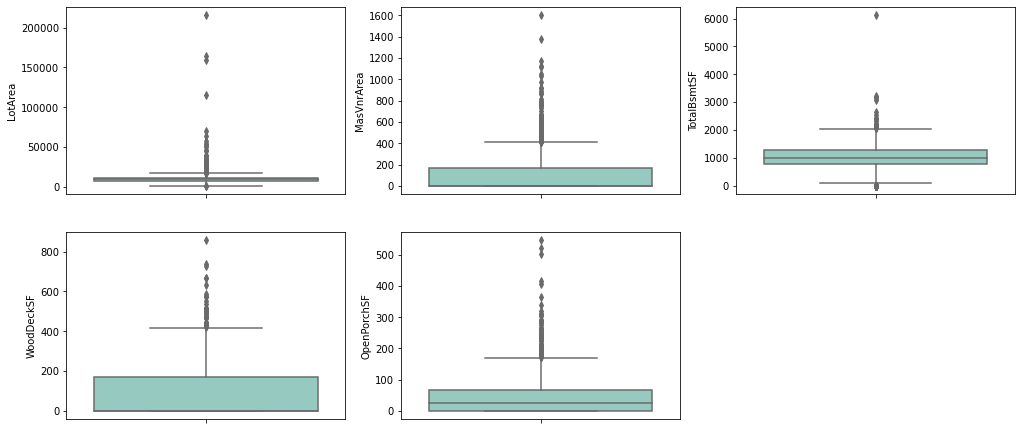

In [106]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = housingInfo)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = housingInfo)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = housingInfo)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = housingInfo)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = housingInfo)
plt.show()



In [107]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = housingInfo['LotArea'].quantile(0.98)
housingInfo = housingInfo[housingInfo["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = housingInfo['MasVnrArea'].quantile(0.98)
housingInfo = housingInfo[housingInfo["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = housingInfo['TotalBsmtSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = housingInfo['WoodDeckSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = housingInfo['OpenPorchSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [108]:
# Determine the percentage of data retained

num_data = round(100*(len(housingInfo)/1460),2)
print(num_data)



93.01


In [109]:

# At this point, we have done -
#1) Check for Duplicates, Empty Rows, Columns
#2) Null values in all categorical columns & Numerical Data
#3) Added Derived Columns - IsRemodelled, BuiltOrRemodelledAge, OldOrNewGarage
#4) Outlier Treatment


### DATA CLEANING & MANIPULATION ENDS HERE

# 3. Data Visualization

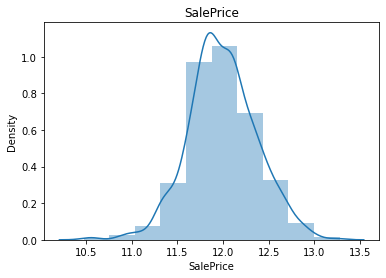

In [110]:


# Visualise the target variable -> SalePrice after transforming the sales price

housingInfo['SalePrice'] = np.log1p(housingInfo['SalePrice'])

plt.title('SalePrice')
sns.distplot(housingInfo['SalePrice'], bins=10)
plt.show()

In [111]:
# Observation - The target value seems to be normalized with some noise.

<Figure size 720x360 with 0 Axes>

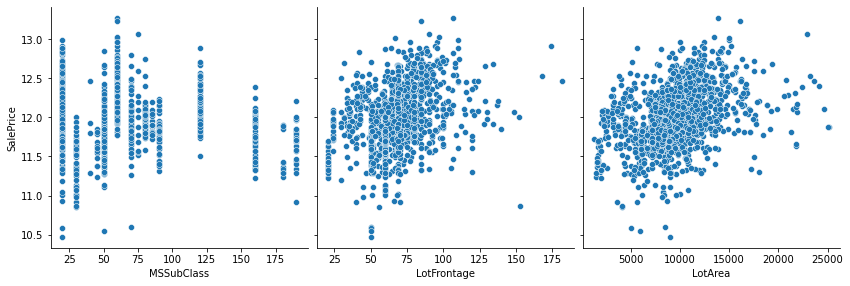

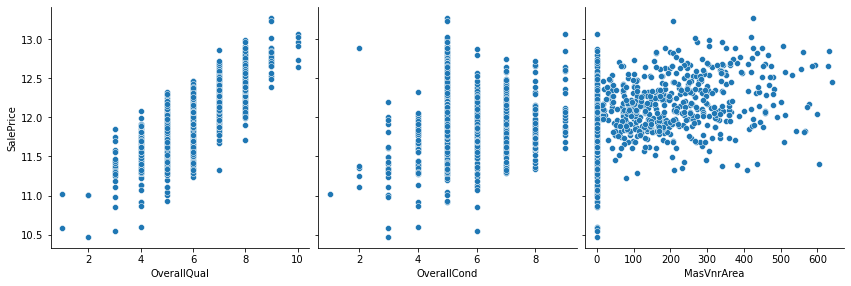

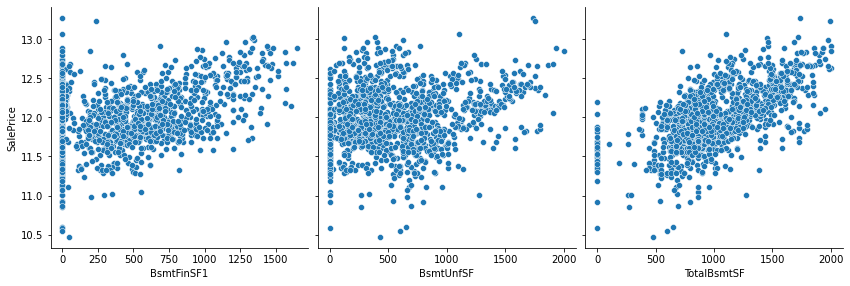

In [112]:
# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(housingInfo, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

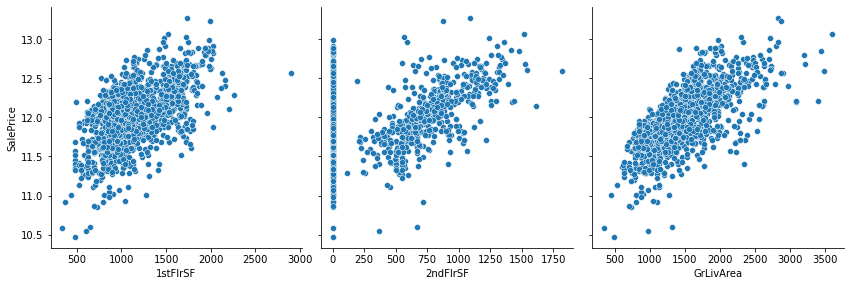

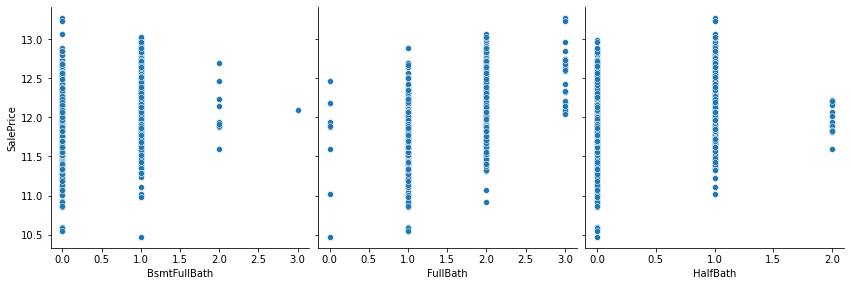

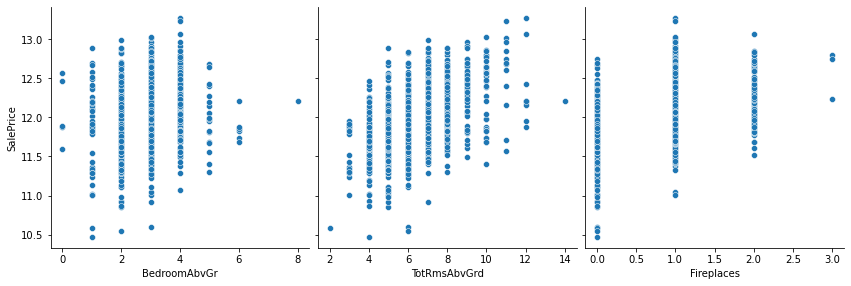

In [113]:
sns.pairplot(housingInfo, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

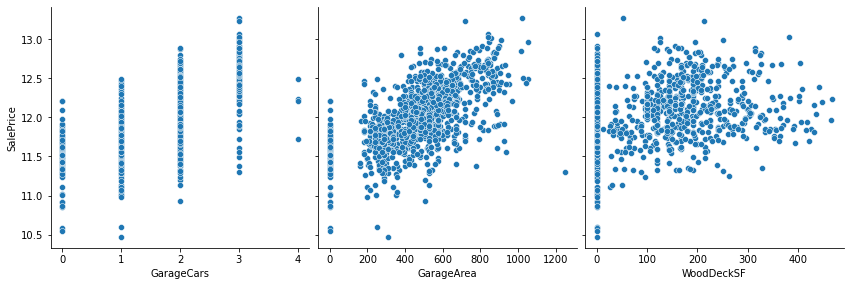

In [114]:
sns.pairplot(housingInfo, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['OpenPorchSF','SalePrice', 'IsRemodelled'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

In [115]:


#Observations :

#- 1stFlrSF, GrLivArea seems to be showing correlation towards right
#- Rest of the variables are too scattered and hence can be understood during further analysis



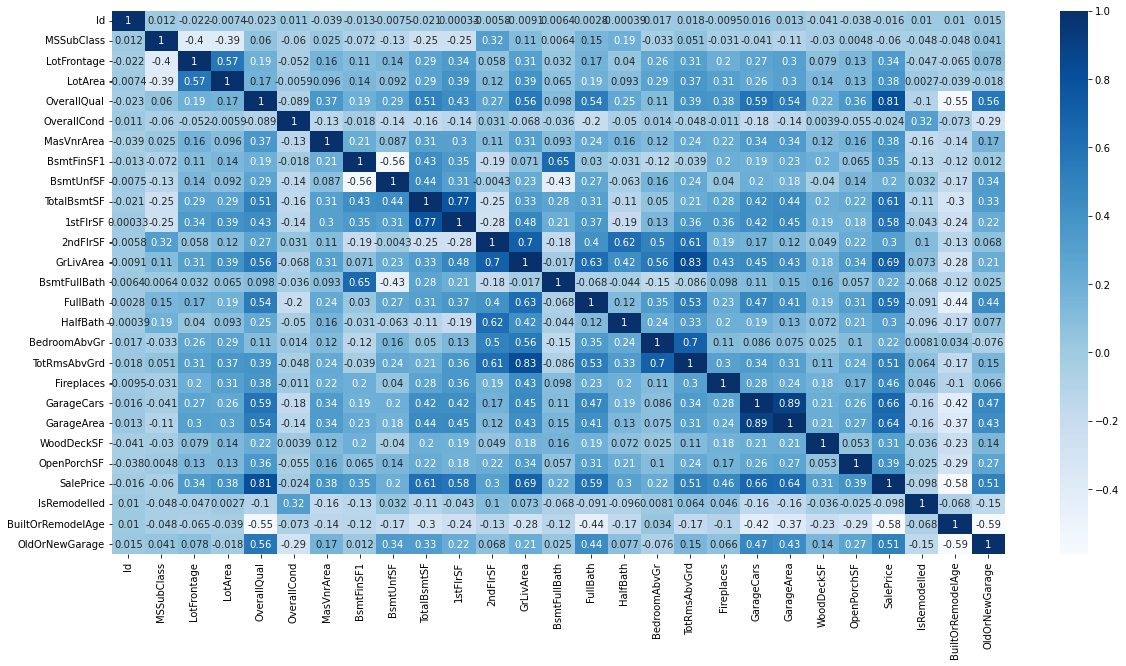

In [116]:
# Check the correlation of numerical columns

plt.figure(figsize = (20, 10))
sns.heatmap(housingInfo.corr(), annot = True, cmap="Blues")
plt.show()

In [117]:
#Removing following columns which shows high correlation

#- TotRmsAbvGrd and GrLivArea show 82%
#- Garage Area and Garage Cars show 88%

# Removing the highly correlated variables

housingInfo.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

# 4.Data Preparation

In [118]:


# Converting categorical data into numercal data
# Creating Dummies

# Since the values of the following fields are ordered list, we shall assign values to them in sequence

# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

housingInfo['d_LotShape'] = housingInfo['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
housingInfo['d_ExterQual'] = housingInfo['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
housingInfo['d_BsmtQual'] = housingInfo['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_BsmtExposure'] = housingInfo['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
housingInfo['d_BsmtFinType1'] = housingInfo['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
housingInfo['d_HeatingQC'] = housingInfo['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_KitchenQual'] = housingInfo['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_FireplaceQu'] = housingInfo['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_GarageFinish'] = housingInfo['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
housingInfo['d_BldgType'] = housingInfo['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 
                                                                 'None': 0 })
housingInfo['d_HouseStyle'] = housingInfo['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
housingInfo['d_Fence'] = housingInfo['Fence'].map({'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'None': 0 })
housingInfo['d_LotConfig'] = housingInfo['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
housingInfo['d_MasVnrType'] = housingInfo['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
housingInfo['d_SaleCondition'] = housingInfo['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                                   'Alloca': 0, 'AdjLand': 0, 'None': 0})
housingInfo.head()


Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood BldgType HouseStyle  ...  d_HeatingQC  d_KitchenQual  \
0      CollgCr     1Fam     2Story  ...            5              4   
1      Veenker     1Fam     1Story  ...            5              3   
2      CollgCr     1Fam     2Story  ...            5              4   
3      Crawfor     1Fam     2Story  ...            4              4   
4      NoRidge     1Fam     2Story  ...            5              4   

  d_FireplaceQu d_GarageFinish d_BldgType d_HouseStyle  d_Fence d_LotConfig  \
0             0              2          1            4        0           5   
1             3              2          1            1        0           2   
2             3              2          1            4        0           5   
3             4              1          1            4        0           4   
4             3              2          1            4        0           2   

  d_MasVnrType d_SaleCondition  
0            1               1  
1            0               1  
2            1               1  
3            0               0  
4            1               1  

[5 rows x 62 columns]

In [119]:
# drop the old columns from which the new columns were derived
# We can also drop the id column as it will not be used any more

housingInfo = housingInfo.drop(['Id', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

housingInfo.head()

MSSubClass MSZoning  LotFrontage  LotArea Neighborhood  OverallQual  \
0          60       RL         65.0     8450      CollgCr            7   
1          20       RL         80.0     9600      Veenker            6   
2          60       RL         68.0    11250      CollgCr            7   
3          70       RL         60.0     9550      Crawfor            7   
4          60       RL         84.0    14260      NoRidge            8   

   OverallCond RoofStyle Exterior1st Exterior2nd  ...  d_HeatingQC  \
0            5     Gable     VinylSd     VinylSd  ...            5   
1            8     Gable     MetalSd     MetalSd  ...            5   
2            5     Gable     VinylSd     VinylSd  ...            5   
3            5     Gable     Wd Sdng     Wd Shng  ...            4   
4            5     Gable     VinylSd     VinylSd  ...            5   

  d_KitchenQual  d_FireplaceQu  d_GarageFinish  d_BldgType  d_HouseStyle  \
0             4              0               2           1             4   
1             3              3               2           1             1   
2             4              3               2           1             4   
3             4              4               1           1             4   
4             4              3               2           1             4   

   d_Fence  d_LotConfig  d_MasVnrType  d_SaleCondition  
0        0            5             1                1  
1        0            2             0                1  
2        0            5             1                1  
3        0            4             0                0  
4        0            2             1                1  

[5 rows x 46 columns]

In [120]:
# For the following columns create dummies

# Creating dummies for MSZoning

d_MSZoning = pd.get_dummies(housingInfo['MSZoning'], prefix='MSZoning', drop_first = True)
housingInfo = pd.concat([housingInfo, d_MSZoning], axis = 1)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(housingInfo['Neighborhood'], prefix='Neighborhood', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Neighborhood], axis = 1)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(housingInfo['RoofStyle'], prefix='RoofStyle', drop_first = True)
housingInfo = pd.concat([housingInfo, d_RoofStyle], axis = 1)

# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(housingInfo['Exterior1st'], prefix='Exterior1st', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Exterior1st], axis = 1)

# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(housingInfo['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Exterior2nd], axis = 1)

# Creating dummies for Foundation

d_Foundation = pd.get_dummies(housingInfo['Foundation'], prefix='Foundation', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Foundation], axis = 1)

# Creating dummies for GarageType

d_GarageType = pd.get_dummies(housingInfo['GarageType'], prefix='GarageType', drop_first = True)
housingInfo = pd.concat([housingInfo, d_GarageType], axis = 1)

housingInfo.head()

MSSubClass MSZoning  LotFrontage  LotArea Neighborhood  OverallQual  \
0          60       RL         65.0     8450      CollgCr            7   
1          20       RL         80.0     9600      Veenker            6   
2          60       RL         68.0    11250      CollgCr            7   
3          70       RL         60.0     9550      Crawfor            7   
4          60       RL         84.0    14260      NoRidge            8   

   OverallCond RoofStyle Exterior1st Exterior2nd  ...  Foundation_PConc  \
0            5     Gable     VinylSd     VinylSd  ...                 1   
1            8     Gable     MetalSd     MetalSd  ...                 0   
2            5     Gable     VinylSd     VinylSd  ...                 1   
3            5     Gable     Wd Sdng     Wd Shng  ...                 0   
4            5     Gable     VinylSd     VinylSd  ...                 1   

  Foundation_Slab  Foundation_Stone  Foundation_Wood  GarageType_Attchd  \
0               0                 0                0                  1   
1               0                 0                0                  1   
2               0                 0                0                  1   
3               0                 0                0                  0   
4               0                 0                0                  1   

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   GarageType_Detchd  GarageType_None  
0                  0                0  
1                  0                0  
2                  0                0  
3                  1                0  
4                  0                0  

[5 rows x 119 columns]

In [121]:
# drop the below columns as we now have new columns derived from these columns

housingInfo = housingInfo.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

housingInfo.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0          60         65.0     8450            7            5       196.0   
1          20         80.0     9600            6            8         0.0   
2          60         68.0    11250            7            5       162.0   
3          70         60.0     9550            7            5         0.0   
4          60         84.0    14260            8            5       350.0   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  Foundation_PConc  \
0         706        150          856       856  ...                 1   
1         978        284         1262      1262  ...                 0   
2         486        434          920       920  ...                 1   
3         216        540          756       961  ...                 0   
4         655        490         1145      1145  ...                 1   

   Foundation_Slab  Foundation_Stone  Foundation_Wood  GarageType_Attchd  \
0                0                 0                0                  1   
1                0                 0                0                  1   
2                0                 0                0                  1   
3                0                 0                0                  0   
4                0                 0                0                  1   

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   GarageType_Detchd  GarageType_None  
0                  0                0  
1                  0                0  
2                  0                0  
3                  1                0  
4                  0                0  

[5 rows x 112 columns]

In [122]:
housingInfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 112 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(36), uint8(73)
memory usage: 521.2 KB


In [123]:
#Observation : All columns in the data set are now numeric !!!

In [124]:
###Train Test Split

In [125]:
# Putting all feature variable to X

X = housingInfo.drop(['SalePrice'], axis=1)
X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0          60         65.0     8450            7            5       196.0   
1          20         80.0     9600            6            8         0.0   
2          60         68.0    11250            7            5       162.0   
3          70         60.0     9550            7            5         0.0   
4          60         84.0    14260            8            5       350.0   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  Foundation_PConc  \
0         706        150          856       856  ...                 1   
1         978        284         1262      1262  ...                 0   
2         486        434          920       920  ...                 1   
3         216        540          756       961  ...                 0   
4         655        490         1145      1145  ...                 1   

   Foundation_Slab  Foundation_Stone  Foundation_Wood  GarageType_Attchd  \
0                0                 0                0                  1   
1                0                 0                0                  1   
2                0                 0                0                  1   
3                0                 0                0                  0   
4                0                 0                0                  1   

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   GarageType_Detchd  GarageType_None  
0                  0                0  
1                  0                0  
2                  0                0  
3                  1                0  
4                  0                0  

[5 rows x 111 columns]

In [126]:
# Putting response variable to y

y = housingInfo['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [127]:
# Scaling the features
from sklearn.preprocessing import scale

# storing column names in cols
# scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None'],
      dtype='object', length=111)

In [128]:
# split into train and test

from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

# 5. Recursive feature elimination (RFE)

In [129]:
#Since there are around 111 features, we will use RFE to get the best 50 features out of the 111 features and 
# use the new features for further analysis

# Running RFE with the output number of the variable equal to 50

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 50)            
rfe = rfe.fit(X_train, y_train)

In [130]:
# Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# assign the 50 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

Variable  rfe_support  rfe_ranking
0             MSSubClass         True            1
1                LotArea         True            1
2            OverallQual         True            1
3            OverallCond         True            1
4             BsmtFinSF1         True            1
5            TotalBsmtSF         True            1
6               1stFlrSF         True            1
7               2ndFlrSF         True            1
8              GrLivArea         True            1
9           BsmtFullBath         True            1
10              HalfBath         True            1
11            Fireplaces         True            1
12            GarageCars         True            1
13            WoodDeckSF         True            1
14          IsRemodelled         True            1
15     BuiltOrRemodelAge         True            1
16        OldOrNewGarage         True            1
17            d_BsmtQual         True            1
18        d_BsmtExposure         True            1
19           d_HeatingQC         True            1
20         d_KitchenQual         True            1
21        d_GarageFinish         True            1
22            d_BldgType         True            1
23          d_HouseStyle         True            1
24       d_SaleCondition         True            1
25           MSZoning_FV         True            1
26           MSZoning_RH         True            1
27           MSZoning_RL         True            1
28           MSZoning_RM         True            1
29  Neighborhood_Crawfor         True            1
30  Neighborhood_Edwards         True            1
31  Neighborhood_MeadowV         True            1
32  Neighborhood_NridgHt         True            1
33  Neighborhood_OldTown         True            1
34    Neighborhood_SWISU         True            1
35  Neighborhood_StoneBr         True            1
36   Exterior1st_BrkComm         True            1
37    Exterior1st_CBlock         True            1
38    Exterior1st_Stucco         True            1
39   Exterior1st_VinylSd         True            1
40   Exterior1st_Wd Sdng         True            1
41    Exterior2nd_CBlock         True            1
42    Exterior2nd_Stucco         True            1
43   Exterior2nd_VinylSd         True            1
44   Exterior2nd_Wd Sdng         True            1
45     Foundation_CBlock         True            1
46      Foundation_PConc         True            1
47       Foundation_Slab         True            1
48      Foundation_Stone         True            1
49    GarageType_CarPort         True            1

In [131]:
# Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]

# Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

# 6. Model Building and Evaluation

Ridge


In [132]:

# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [133]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
21        10.0         -0.078199        -0.084210                1
20         9.0         -0.078155        -0.084216                2
19         8.0         -0.078110        -0.084221                3
18         7.0         -0.078065        -0.084226                4
17         6.0         -0.078021        -0.084230                5
22          20         -0.078536        -0.084237                6
16         5.0         -0.077980        -0.084269                7
15         4.0         -0.077942        -0.084338                8
14         3.0         -0.077905        -0.084421                9
23          50         -0.079120        -0.084479               10
13         2.0         -0.077864        -0.084528               11
12         1.0         -0.077825        -0.084660               12
11         0.9         -0.077822        -0.084680               13
10         0.8         -0.077820        -0.084701               14
9          0.7         -0.077819        -0.084723               15
8          0.6         -0.077818        -0.084745               16
7          0.5         -0.077817        -0.084768               17
6          0.4         -0.077816        -0.084791               18
5          0.3         -0.077816        -0.084816               19
4          0.2         -0.077817        -0.084841               20
3          0.1         -0.077818        -0.084868               21
2         0.01         -0.077820        -0.084897               22
1        0.001         -0.077821        -0.084900               23
0       0.0001         -0.077821        -0.084900               24
24         100         -0.079852        -0.084971               25
25         500         -0.086269        -0.090141               26

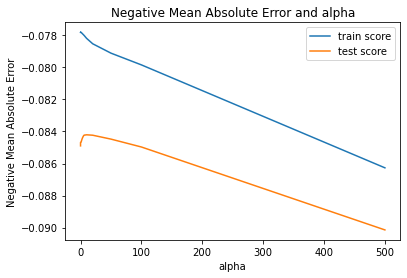

In [134]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [135]:
# get the best estimator for lambda

ridge_model_cv.best_estimator_


Ridge(alpha=10.0)

In [136]:
# check the coefficient values with lambda = 10

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-0.00939379,  0.02195883,  0.06836313,  0.04504004,  0.03283145,
        0.04622329,  0.02473729,  0.02464272,  0.07905787,  0.01033503,
        0.01605522,  0.02132515,  0.03547342,  0.01020595, -0.01242812,
       -0.01939627,  0.01483745,  0.01386043,  0.01541266,  0.01864798,
        0.01617949,  0.0159313 , -0.01060815,  0.00635291,  0.01553711,
        0.05940973,  0.02242101,  0.08771411,  0.05804592,  0.0255173 ,
       -0.01102408, -0.00876949,  0.02236278, -0.01326178, -0.00895594,
        0.0168362 , -0.00969267, -0.00198895,  0.01391614, -0.03291536,
       -0.03058367, -0.00198895, -0.01828222,  0.02837442,  0.0195485 ,
        0.01886293,  0.0433776 ,  0.01775497,  0.00594218, -0.0097301 ])

In [137]:
# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.013743970339162415

In [138]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

Features  Coefficient
0             MSSubClass      -0.0094
1                LotArea       0.0220
2            OverallQual       0.0684
3            OverallCond       0.0450
4             BsmtFinSF1       0.0328
5            TotalBsmtSF       0.0462
6               1stFlrSF       0.0247
7               2ndFlrSF       0.0246
8              GrLivArea       0.0791
9           BsmtFullBath       0.0103
10              HalfBath       0.0161
11            Fireplaces       0.0213
12            GarageCars       0.0355
13            WoodDeckSF       0.0102
14          IsRemodelled      -0.0124
15     BuiltOrRemodelAge      -0.0194
16        OldOrNewGarage       0.0148
17            d_BsmtQual       0.0139
18        d_BsmtExposure       0.0154
19           d_HeatingQC       0.0186
20         d_KitchenQual       0.0162
21        d_GarageFinish       0.0159
22            d_BldgType      -0.0106
23          d_HouseStyle       0.0064
24       d_SaleCondition       0.0155
25           MSZoning_FV       0.0594
26           MSZoning_RH       0.0224
27           MSZoning_RL       0.0877
28           MSZoning_RM       0.0580
29  Neighborhood_Crawfor       0.0255
30  Neighborhood_Edwards      -0.0110
31  Neighborhood_MeadowV      -0.0088
32  Neighborhood_NridgHt       0.0224
33  Neighborhood_OldTown      -0.0133
34    Neighborhood_SWISU      -0.0090
35  Neighborhood_StoneBr       0.0168
36   Exterior1st_BrkComm      -0.0097
37    Exterior1st_CBlock      -0.0020
38    Exterior1st_Stucco       0.0139
39   Exterior1st_VinylSd      -0.0329
40   Exterior1st_Wd Sdng      -0.0306
41    Exterior2nd_CBlock      -0.0020
42    Exterior2nd_Stucco      -0.0183
43   Exterior2nd_VinylSd       0.0284
44   Exterior2nd_Wd Sdng       0.0195
45     Foundation_CBlock       0.0189
46      Foundation_PConc       0.0434
47       Foundation_Slab       0.0178
48      Foundation_Stone       0.0059
49    GarageType_CarPort      -0.0097

In [139]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

{'MSSubClass': -0.0094,
 'LotArea': 0.022,
 'OverallQual': 0.0684,
 'OverallCond': 0.045,
 'BsmtFinSF1': 0.0328,
 'TotalBsmtSF': 0.0462,
 '1stFlrSF': 0.0247,
 '2ndFlrSF': 0.0246,
 'GrLivArea': 0.0791,
 'BsmtFullBath': 0.0103,
 'HalfBath': 0.0161,
 'Fireplaces': 0.0213,
 'GarageCars': 0.0355,
 'WoodDeckSF': 0.0102,
 'IsRemodelled': -0.0124,
 'BuiltOrRemodelAge': -0.0194,
 'OldOrNewGarage': 0.0148,
 'd_BsmtQual': 0.0139,
 'd_BsmtExposure': 0.0154,
 'd_HeatingQC': 0.0186,
 'd_KitchenQual': 0.0162,
 'd_GarageFinish': 0.0159,
 'd_BldgType': -0.0106,
 'd_HouseStyle': 0.0064,
 'd_SaleCondition': 0.0155,
 'MSZoning_FV': 0.0594,
 'MSZoning_RH': 0.0224,
 'MSZoning_RL': 0.0877,
 'MSZoning_RM': 0.058,
 'Neighborhood_Crawfor': 0.0255,
 'Neighborhood_Edwards': -0.011,
 'Neighborhood_MeadowV': -0.0088,
 'Neighborhood_NridgHt': 0.0224,
 'Neighborhood_OldTown': -0.0133,
 'Neighborhood_SWISU': -0.009,
 'Neighborhood_StoneBr': 0.0168,
 'Exterior1st_BrkComm': -0.0097,
 'Exterior1st_CBlock': -0.002,
 'Exte

RFE

In [140]:


# Do an RFE to minimise the features to 15
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_ridge, y_train)



In [141]:


# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df



Features  rfe_support  rfe_ranking  Coefficient
11       MSZoning_RL         True            1       0.0877
5          GrLivArea         True            1       0.0791
1        OverallQual         True            1       0.0684
9        MSZoning_FV         True            1       0.0594
12       MSZoning_RM         True            1       0.0580
4        TotalBsmtSF         True            1       0.0462
2        OverallCond         True            1       0.0450
14  Foundation_PConc         True            1       0.0434
7         GarageCars         True            1       0.0355
3         BsmtFinSF1         True            1       0.0328

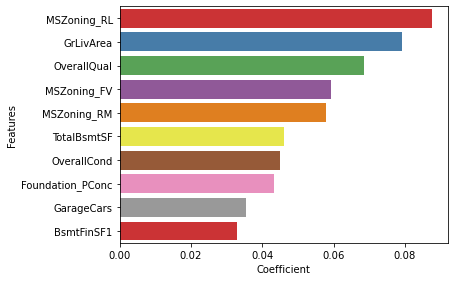

In [142]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp1_df)
plt.show()

In [67]:
#Observation - The above graph displays the top 10 variables based on the Ridge Regression model that are significant 
# in predicting the price of a house.

Lasso

In [68]:
lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [69]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
3       0.0004         -0.078032        -0.084369                1
4       0.0005         -0.078172        -0.084373                2
2       0.0003         -0.077933        -0.084423                3
1       0.0002         -0.077871        -0.084521                4
0       0.0001         -0.077827        -0.084659                5
5        0.001         -0.078855        -0.084718                6
6        0.002         -0.079755        -0.085199                7
7        0.003         -0.080260        -0.085460                8
8        0.004         -0.080756        -0.085879                9
9        0.005         -0.081337        -0.086341               10
10        0.01         -0.085113        -0.089094               11

In [70]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()



In [71]:
# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0004)

In [72]:
# check the coefficient values with lambda = 0.0004

alpha = 0.0004

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([-0.00915998,  0.02165857,  0.06965527,  0.04488911,  0.03336601,
        0.04611213,  0.00319177, -0.        ,  0.10754074,  0.00971068,
        0.01518099,  0.02077453,  0.03633809,  0.00995221, -0.01170117,
       -0.01884216,  0.01427036,  0.01287514,  0.01598228,  0.01832079,
        0.01545907,  0.01631163, -0.01056321,  0.00474103,  0.0149871 ,
        0.07057917,  0.02764822,  0.10983987,  0.07651055,  0.0251925 ,
       -0.0107593 , -0.00795497,  0.02202384, -0.01367778, -0.00996439,
        0.01637499, -0.00955042, -0.00310145,  0.01172176, -0.0294678 ,
       -0.02985886, -0.0006841 , -0.01620654,  0.02493197,  0.01818188,
        0.01800232,  0.04303123,  0.01657175,  0.00631248, -0.00879407])

In [73]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.013556413314276771

In [74]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

Features  Coefficient
0             MSSubClass      -0.0092
1                LotArea       0.0217
2            OverallQual       0.0697
3            OverallCond       0.0449
4             BsmtFinSF1       0.0334
5            TotalBsmtSF       0.0461
6               1stFlrSF       0.0032
7              GrLivArea       0.1075
8           BsmtFullBath       0.0097
9               HalfBath       0.0152
10            Fireplaces       0.0208
11            GarageCars       0.0363
12            WoodDeckSF       0.0100
13          IsRemodelled      -0.0117
14     BuiltOrRemodelAge      -0.0188
15        OldOrNewGarage       0.0143
16            d_BsmtQual       0.0129
17        d_BsmtExposure       0.0160
18           d_HeatingQC       0.0183
19         d_KitchenQual       0.0155
20        d_GarageFinish       0.0163
21            d_BldgType      -0.0106
22          d_HouseStyle       0.0047
23       d_SaleCondition       0.0150
24           MSZoning_FV       0.0706
25           MSZoning_RH       0.0276
26           MSZoning_RL       0.1098
27           MSZoning_RM       0.0765
28  Neighborhood_Crawfor       0.0252
29  Neighborhood_Edwards      -0.0108
30  Neighborhood_MeadowV      -0.0080
31  Neighborhood_NridgHt       0.0220
32  Neighborhood_OldTown      -0.0137
33    Neighborhood_SWISU      -0.0100
34  Neighborhood_StoneBr       0.0164
35   Exterior1st_BrkComm      -0.0096
36    Exterior1st_CBlock      -0.0031
37    Exterior1st_Stucco       0.0117
38   Exterior1st_VinylSd      -0.0295
39   Exterior1st_Wd Sdng      -0.0299
40    Exterior2nd_CBlock      -0.0007
41    Exterior2nd_Stucco      -0.0162
42   Exterior2nd_VinylSd       0.0249
43   Exterior2nd_Wd Sdng       0.0182
44     Foundation_CBlock       0.0180
45      Foundation_PConc       0.0430
46       Foundation_Slab       0.0166
47      Foundation_Stone       0.0063
48    GarageType_CarPort      -0.0088

In [143]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'MSSubClass': -0.00915998381099718,
 'LotArea': 0.021658568234802264,
 'OverallQual': 0.06965526609648405,
 'OverallCond': 0.044889110314328684,
 'BsmtFinSF1': 0.03336600821268066,
 'TotalBsmtSF': 0.04611213340270227,
 '1stFlrSF': 0.003191765104352835,
 '2ndFlrSF': -0.0,
 'GrLivArea': 0.1075407398883313,
 'BsmtFullBath': 0.009710677163716461,
 'HalfBath': 0.015180991563664582,
 'Fireplaces': 0.020774526969382937,
 'GarageCars': 0.03633809261416283,
 'WoodDeckSF': 0.009952205479949489,
 'IsRemodelled': -0.011701170894639486,
 'BuiltOrRemodelAge': -0.018842161705134964,
 'OldOrNewGarage': 0.014270363551605384,
 'd_BsmtQual': 0.012875138576447887,
 'd_BsmtExposure': 0.015982276173717305,
 'd_HeatingQC': 0.018320789969424323,
 'd_KitchenQual': 0.01545906957733494,
 'd_GarageFinish': 0.016311632317918892,
 'd_BldgType': -0.010563209351042437,
 'd_HouseStyle': 0.004741026631013698,
 'd_SaleCondition': 0.014987101050461162,
 'MSZoning_FV': 0.0705791658811704,
 'MSZoning_RH': 0.02764821503202

RFE

In [144]:
# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [145]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

Features  rfe_support  rfe_ranking  Coefficient
11       MSZoning_RL         True            1     0.109840
5          GrLivArea         True            1     0.107541
12       MSZoning_RM         True            1     0.076511
9        MSZoning_FV         True            1     0.070579
1        OverallQual         True            1     0.069655
4        TotalBsmtSF         True            1     0.046112
2        OverallCond         True            1     0.044889
14  Foundation_PConc         True            1     0.043031
7         GarageCars         True            1     0.036338
3         BsmtFinSF1         True            1     0.033366

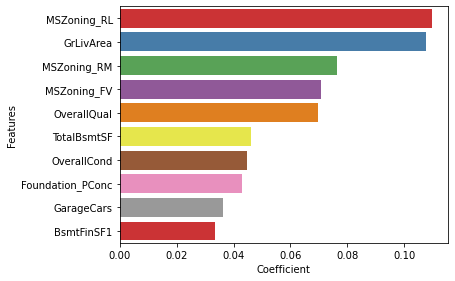

In [146]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp2_df)
plt.show()

In [147]:
#Observation - The above graph displays the top 10 variables based on the Lasso Regression model that are 
# significant in predicting the price of a house.

# Conclusion





    The optimal lambda value in case of Ridge and Lasso is as below:
        Ridge - 10
        Lasso - 0.0004

    The Mean Squared error in case of Ridge and Lasso are:
        Ridge - 0.013743
        Lasso - 0.013556

    The Mean Squared Error of Lasso is slightly lower than that of Ridge

    Also, since Lasso helps in feature reduction (as the coefficient value of one of the feature became 0), Lasso has a better edge over Ridge.

    Hence based on Lasso, the factors that generally affect the price are the Zoning classification, Living area square feet, Overall quality and condition of the house, Foundation type of the house, Number of cars that can be accomodated in the garage, Total basement area in square feet and the Basement finished square feet area

Therefore, the variables predicted by Lasso in the above bar chart as significant variables for predicting the price of a house.